In [1]:
!pip3 install pyro-ppl 

In [2]:
import os
import torch
import pyro
import logging
import matplotlib.pyplot as plt


In [3]:
%matplotlib inline
plt.style.use('default')
logging.basicConfig(format='%(message)s', level=logging.INFO)

## Generate artificial data set

In [5]:
import numpy as np

#y = ax + b
noise_std = 1.0
a = 4.0
b = -2.0
train_samples = 5000

X_train = np.random.uniform(low = -5, high = 5, size = train_samples)
y_train = np.dot(X_train, a) + b + np.random.normal(0, noise_std, size=train_samples)

X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)

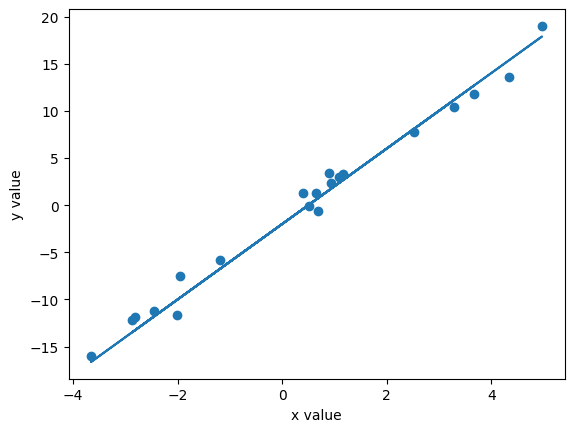

In [6]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:20], y_train[:20])
plt.plot(X_train[:20], np.dot(X_train[:20], a) + b)
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

In [14]:
import pyro.distributions as dist

print (X_train.shape)

def model(X_train, y_train):
    a = pyro.sample("a", dist.Normal(0., 1.))
    b = pyro.sample("b", dist.Normal(0., 10.))
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 5.))
    mean = a*X_train + b

    with pyro.plate("data", len(X_train)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=y_train)

torch.Size([5000])


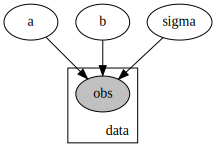

In [8]:
pyro.render_model(model, model_args=(X_train, y_train))

## Variational inference

In [9]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.002})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Elbo loss: 70958.29556417465
Elbo loss: 49847.43044382334
Elbo loss: 47247.056391596794
Elbo loss: 35986.99921286106
Elbo loss: 33810.0358966589
Elbo loss: 28433.103819847107
Elbo loss: 27536.09386229515
Elbo loss: 25362.007328629494
Elbo loss: 23357.303773641586
Elbo loss: 22358.381481289864
Elbo loss: 20876.09664416313
Elbo loss: 20094.95322906971
Elbo loss: 18771.765876173973
Elbo loss: 19056.456441521645
Elbo loss: 17391.275472044945
Elbo loss: 17473.392042040825
Elbo loss: 16210.069234967232
Elbo loss: 14966.777783989906
Elbo loss: 15580.758277893066
Elbo loss: 15021.080682992935
Elbo loss: 14389.97775042057
Elbo loss: 13891.383989930153
Elbo loss: 13760.00618159771
Elbo loss: 13686.481855750084
Elbo loss: 13163.817154288292
Elbo loss: 13275.190660476685
Elbo loss: 13139.638199448586
Elbo loss: 12315.809720873833
Elbo loss: 12149.273030519485
Elbo loss: 12260.702964425087
Elbo loss: 12205.17909348011
Elbo loss: 11855.781104803085
Elbo loss: 11838.991833209991
Elbo loss: 11623.4140

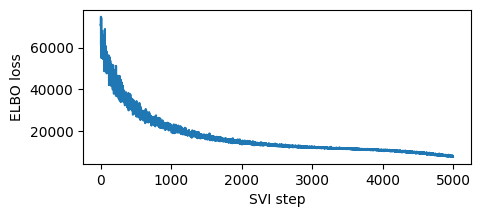

In [10]:
pyro.clear_param_store()
losses = []
for step in range(5000):
    loss = svi.step(X_train, y_train)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [11]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 4.005273
AutoNormal.scales.a 0.059399
AutoNormal.locs.b -2.0173588
AutoNormal.scales.b 0.045104947
AutoNormal.locs.sigma -0.86132807
AutoNormal.scales.sigma 0.09090831


## MCMC Inference


In [12]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=1000, num_samples=5000)
mcmc.run(X_train, y_train)
posterior_samples = mcmc.get_samples()


Sample: 100%|██████████| 6000/6000 [01:19, 75.53it/s, step size=7.23e-01, acc. prob=0.921]


In [13]:
print(posterior_samples['a'].mean())
print(posterior_samples['b'].mean())

tensor(4.0061)
tensor(-2.0065)
